In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. 数据总览

In [3]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### 显然测试集没有survived这一栏

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### 显然，小于418的存在缺失值。

绘制存活比例

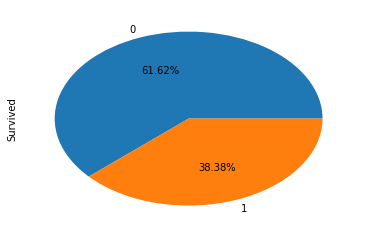

In [7]:
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

# 2. 处理缺失值的方法

- （1）如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行；

- （2）如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。比如在哪儿上船Embarked这一属性（共有三个上船地点），缺失俩值，可以用众数赋值

In [8]:
# 先去掉缺失值，再求取众数
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

- （3）对于标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱。

In [9]:
train_data['Cabin'] = train_data['Cabin'].fillna('U0')

- （4）使用回归 随机森林等模型来预测缺失属性的值。

    因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。这里使用随机森林预测模型，选取数据集中的数值属性作为特征（因为sklearn的模型只能处理数值属性，所以这里先仅选取数值特征，但在实际的应用中需要将非数值特征转换为数值特征）

In [10]:
from sklearn.ensemble import RandomForestRegressor

/home/yxq/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
# 选择测试数据预测年龄
age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1) ##########################################################
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']]= predictAges

处理之后的数据：

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 3. 分析数据关系

## (1)性别与生存的关系 Sex

In [13]:
train_data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

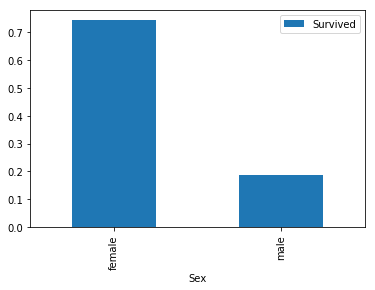

In [14]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

## （2）船舱等级和生存与否的关系 Pclass

In [15]:
train_data.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

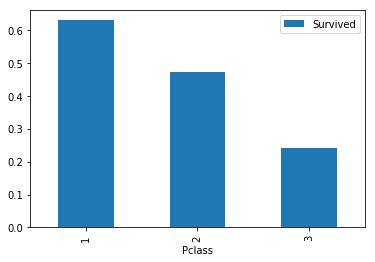

In [16]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

## (3)年龄与存活与否的关系

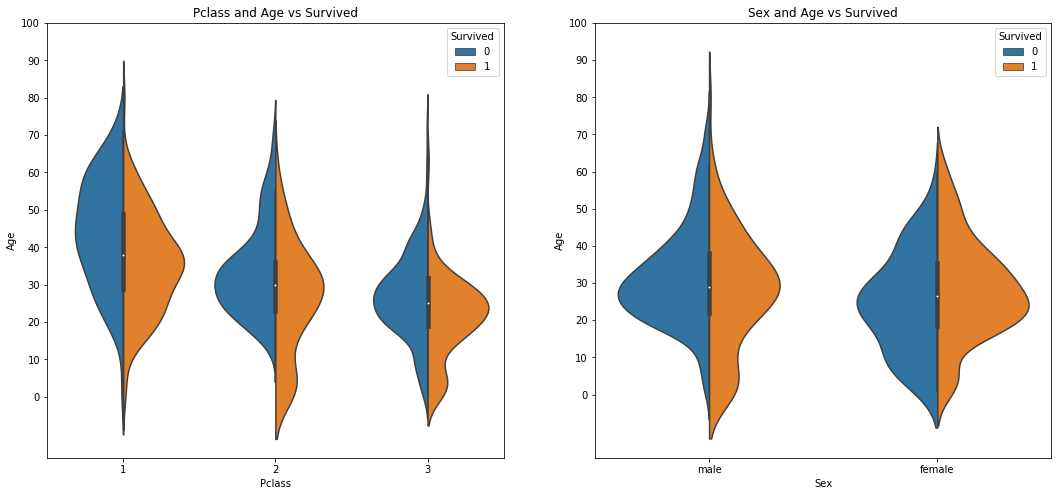

In [17]:
fig, ax = plt.subplots(1,2,figsize = (18,8))
sns.violinplot("Pclass","Age",hue = "Survived",data = train_data, split = True, ax = ax[0])
ax[0].set_title("Pclass and Age vs Survived")
ax[0].set_yticks(range(0,110,10))

sns.violinplot("Sex","Age",hue = "Survived",data = train_data, split = True, ax = ax[1])
ax[1].set_title("Sex and Age vs Survived")
ax[1].set_yticks(range(0,110,10))

plt.show()

分析总体年龄分布

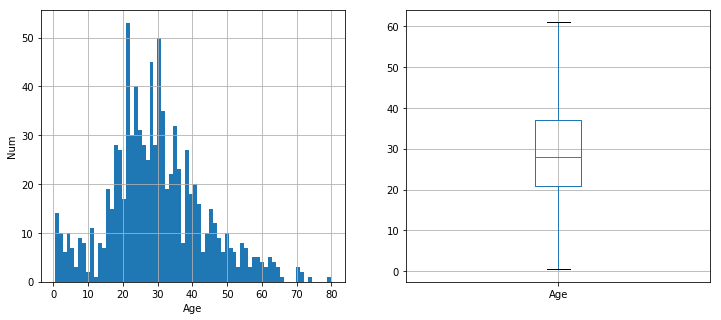

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(121)
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age',showfliers=False)
plt.show()

不同年龄下，生存和非生存的分布情况

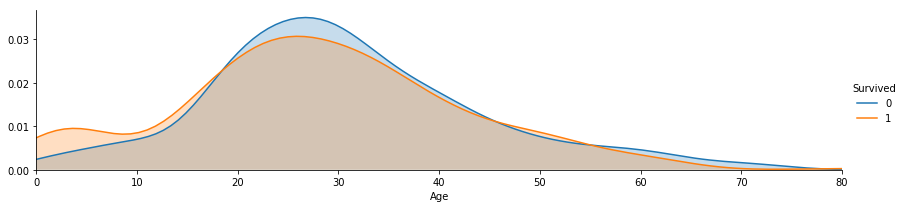

In [19]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4) #################################################################
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

不同年龄下的平均生存率

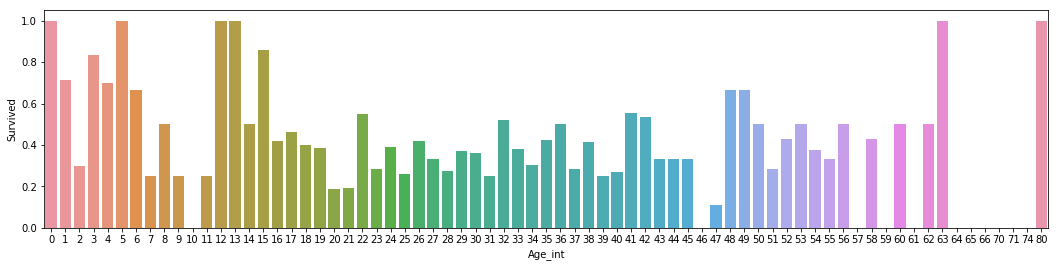

In [20]:
# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data["Age_int"] = train_data["Age"].astype(int)
average_age = train_data[["Age_int", "Survived"]].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int', y='Survived', data=average_age)

In [21]:
train_data['Age'].describe()

count    891.000000
mean      29.657532
std       13.739181
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

按照年龄，将乘客划分为儿童、少年、成年和老年，分析四个群体的生还状况

In [22]:
bins = [0,12,18,65,100]
train_data['Age_group'] = pd.cut(train_data['Age'],bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

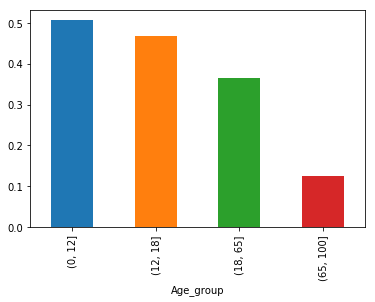

In [23]:
by_age.plot(kind='bar')

## （4）称呼与存活与否的关系 Name

In [24]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


不同称呼与生存率的关系

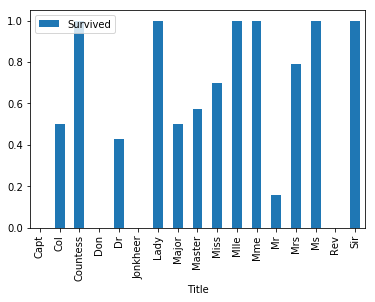

In [25]:
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

观察名字长度与生存的关系

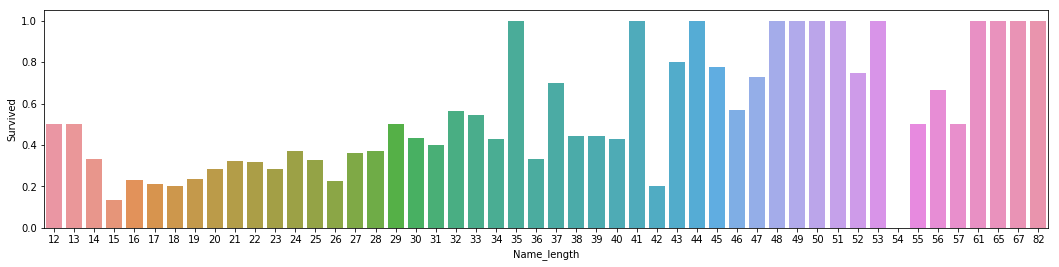

In [26]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)


## (5)有无兄弟姐妹与存活与否的关系 Sibsp ################(5-11)再看再完善

In [27]:
# 将数据分为有兄弟姐妹的和没有兄弟姐妹的两组：
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

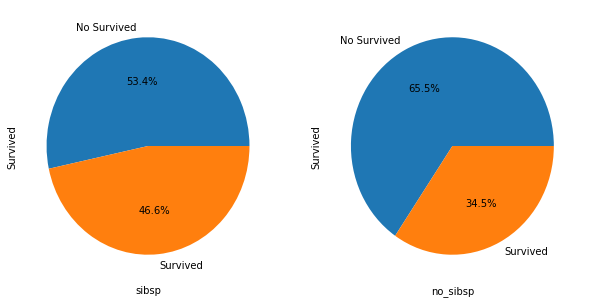

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_sibsp')

plt.show()


## (6)有无父母子女和存活与否的关系 Parch

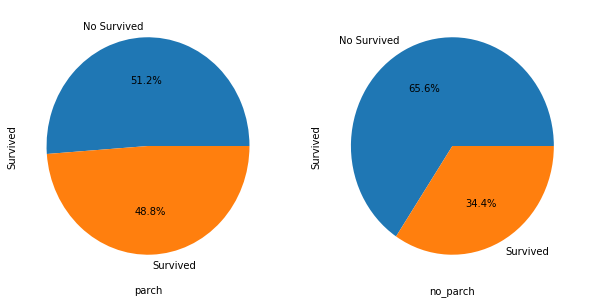

In [29]:
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_parch')

plt.show()


## (7)亲友人数和存活与否的关系 SibSp&Parch

Text(0.5,1,'SibSp and Survived')

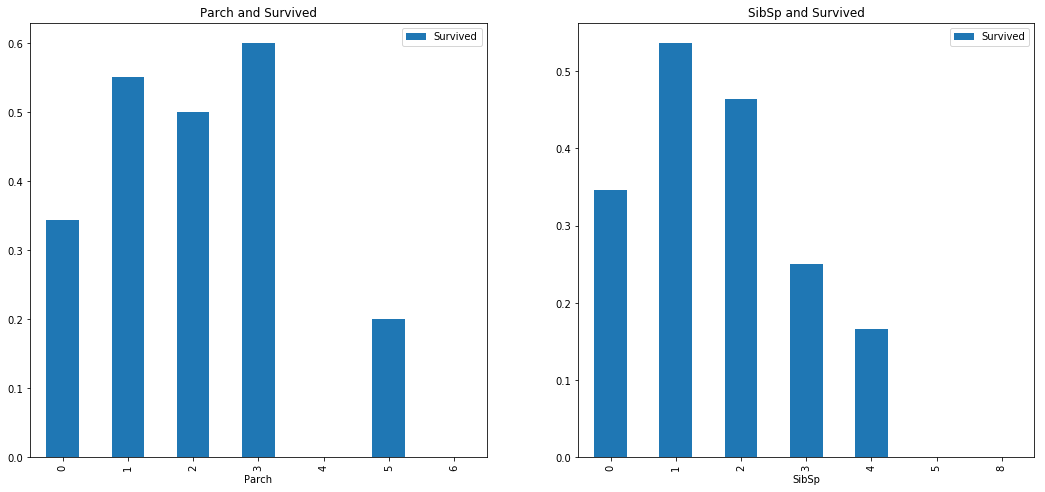

In [30]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')


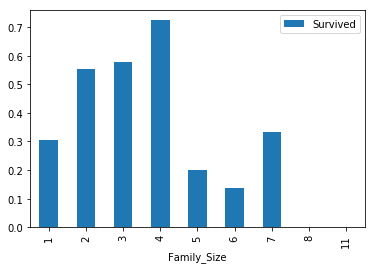

In [31]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()


## (8) 票价分布和存活与否的关系 Fare

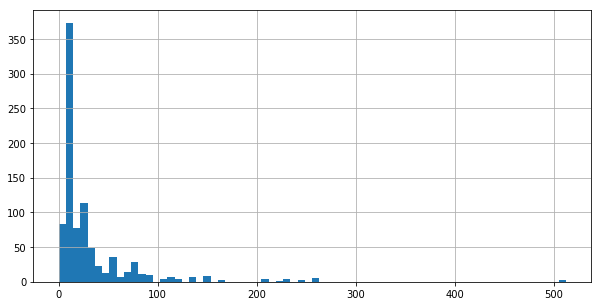

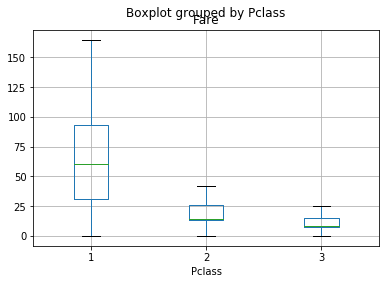

In [32]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins = 70)

train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

In [33]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

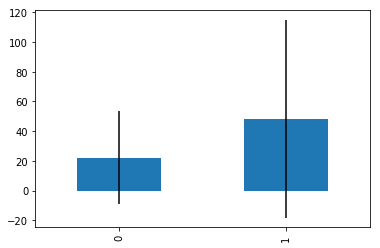

In [34]:
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

plt.show()

## (9)船舱类型和存活与否的关系 Cabin

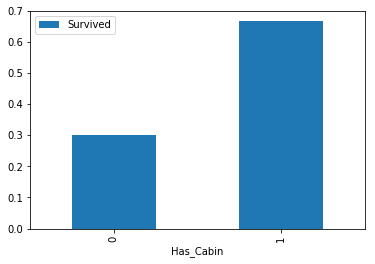

In [35]:
# Replace missing values with "U0"
train_data.loc[train_data.Cabin.isnull(), 'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

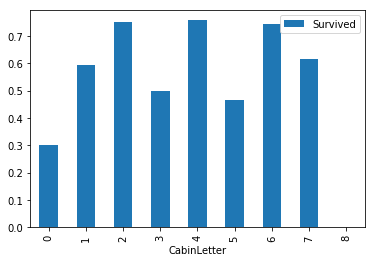

In [36]:
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()

## (10) 港口和存活与否的关系

Text(0.5,1,'Embarked and Survived')

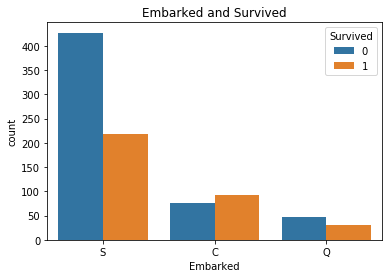

In [37]:
sns.countplot('Embarked', hue='Survived', data=train_data)
plt.title('Embarked and Survived')

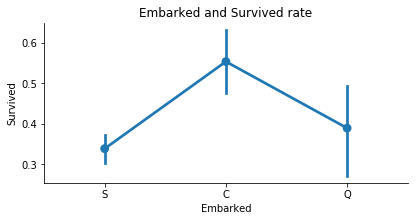

In [38]:
sns.factorplot('Embarked', 'Survived', data=train_data, size=3, aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

## (11)其他可能和存活与否有关的特征

# 4. 变量转换

## 定性转换

### 1. 类别变量dummy

In [39]:
embark_dummies = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'],axis=1,inplace=True)

In [40]:
embark_dummies.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [41]:
embark_dummies = train_data[['S','C','Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


### 2. Factorizing

dummy不好处理Cabin（船舱号）这种标称属性，因为他出现的变量比较多。所以Pandas有一个方法叫做factorize()，它可以创建一些数字，来表示类别变量，对每一个类别映射一个ID，这种映射最后只生成一个特征，不像dummy那样生成多个特征。

In [ ]:
# Replace missing values with "U0"
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'

In [53]:
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group()) # 一个一个函数查，就明白了
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'].head()

0    U
1    C
2    U
3    C
4    U
Name: CabinLetter, dtype: object

In [56]:
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data['CabinLetter'].head()

0    0
1    1
2    0
3    1
4    0
Name: CabinLetter, dtype: int64

## 定量转换

### 1. Scaling

In [57]:
# 对年龄进行归一化
from sklearn import preprocessing

assert np.size(train_data['Age']) == 891
# StandardScaler will subtract the mean from each value then scale to the unit variance
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))

In [58]:
train_data['Age_scaled'].head()

0   -0.557663
1    0.607544
2   -0.266361
3    0.389068
4    0.389068
Name: Age_scaled, dtype: float64

### 2. Binning 

将连续数值离散化处理

In [59]:
# 对Fare进行离散化处理
train_data['Fare_bin'] = pd.qcut(train_data['Fare'], 5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

数据Bining之后，要么factorize，要么dummies

In [60]:
# factorize
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]

# dummies
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train_data = pd.concat([train_data, fare_bin_dummies_df], axis=1)

In [74]:
fare_bin_dummies_df.head()

,"Fare_(-0.001, 7.854]","Fare_(7.854, 10.5]","Fare_(10.5, 21.679]","Fare_(21.679, 39.688]","Fare_(39.688, 512.329]"
0,1,0,0,0,0
1,0,0,0,0,1
2,0,1,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0


# 5. 特征工程